In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Load Dataset

In [2]:
df = pd.read_csv("../dataset.csv")

## Feature and Target Separation

In [3]:
X = df.drop('Result', axis=1)
y = df['Result']

# Model and K-Fold Initialization

In [4]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# Results Storage for Each Fold

In [5]:
accuracies, precisions, recalls, f1_scores = [], [], [], []
tpr_list, fpr_list, tnr_list, fnr_list = [], [], [], []
tp_list, fp_list, tn_list, fn_list = [], [], [], []
total_list = []
# Lists to store training and testing times
train_times = []
test_times = []

# Pre-processing and Modeling

In [6]:
feature_names = X.columns
importance_list = []

SELECT_K = 25

# Scaling data dilakukan di luar K-Fold (sebelum looping)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    # Split data yang sudah di-scaling sebelumnya
    X_train_scaled, X_test_scaled = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Hitung F-score dan p-value
    f_scores, p_values = f_classif(X_train_scaled, y_train)

    # Pilih index fitur dengan p-value terkecil
    selected_indices = np.argsort(p_values)[:SELECT_K]
    selected_feature_names = feature_names[selected_indices]
    selected_f_scores = f_scores[selected_indices]

    # Seleksi fitur berdasarkan p-value
    X_train_selected = X_train_scaled[:, selected_indices]
    X_test_selected = X_test_scaled[:, selected_indices]

    # Training dan ukur waktu training
    train_start_time = time.time()
    rf_model.fit(X_train_selected, y_train)
    train_end_time = time.time()
    train_time = train_end_time - train_start_time
    train_times.append(train_time)

    # Testing dan ukur waktu testing
    test_start_time = time.time()
    y_pred = rf_model.predict(X_test_selected)
    test_end_time = time.time()
    test_time = test_end_time - test_start_time
    test_times.append(test_time)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])
    TN, FP, FN, TP = cm.ravel()
    total = TP + TN + FP + FN

    # Simpan nilai absolut
    tp_list.append(TP)
    fp_list.append(FP)
    tn_list.append(TN)
    fn_list.append(FN)
    total_list.append(total)

    # Simpan nilai metrik
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, pos_label=1, zero_division=0))
    recalls.append(recall_score(y_test, y_pred, pos_label=1, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred, pos_label=1, zero_division=0))

    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
    tnr = TN / (TN + FP) if (TN + FP) > 0 else 0
    fnr = FN / (FN + TP) if (FN + TP) > 0 else 0

    tpr_list.append(tpr)
    fpr_list.append(fpr)
    tnr_list.append(tnr)
    fnr_list.append(fnr)

    # Simpan feature importance dari fitur terpilih
    importance_df = pd.DataFrame({
        'Feature': selected_feature_names,
        'Importance': selected_f_scores
    }).sort_values(by='Importance', ascending=False)

    importance_list.append(importance_df)

# Absolute Average Values

In [7]:
avg_tp, avg_fp, avg_tn, avg_fn = np.mean(tp_list), np.mean(fp_list), np.mean(tn_list), np.mean(fn_list)
avg_total = np.mean(total_list)

# 10-Fold Evaluation Results

In [8]:
print("\n--- Final Evaluation Results (All in Percentage) ---")
print("General Metrics:")
print(f"  Average Accuracy    : {np.mean(accuracies) * 100:.2f}%")
print(f"  Average Precision   : {np.mean(precisions) * 100:.2f}%")
print(f"  Average Recall      : {np.mean(recalls) * 100:.2f}%")
print(f"  Average F1-Score    : {np.mean(f1_scores) * 100:.2f}%")

print("\nExecution Time:")
print(f"  Average Training Time : {np.mean(train_times):.4f} seconds")
print(f"  Average Testing Time  : {np.mean(test_times):.4f} seconds")
print(f"  Total Training Time   : {np.sum(train_times):.4f} seconds")
print(f"  Total Testing Time    : {np.sum(test_times):.4f} seconds")


--- Final Evaluation Results (All in Percentage) ---
General Metrics:
  Average Accuracy    : 97.17%
  Average Precision   : 96.80%
  Average Recall      : 98.16%
  Average F1-Score    : 97.48%

Execution Time:
  Average Training Time : 0.6910 seconds
  Average Testing Time  : 0.0231 seconds
  Total Training Time   : 6.9095 seconds
  Total Testing Time    : 0.2314 seconds


# Average Confusion Matrix per Fold

In [9]:
print("\nAverage Confusion Matrix per Fold (absolute and percentage):")
print(f"  TP: {avg_tp:.2f} ({avg_tp / avg_total * 100:.2f}%)")
print(f"  FP: {avg_fp:.2f} ({avg_fp / avg_total * 100:.2f}%)")
print(f"  TN: {avg_tn:.2f} ({avg_tn / avg_total * 100:.2f}%)")
print(f"  FN: {avg_fn:.2f} ({avg_fn / avg_total * 100:.2f}%)")

# Calculate FPR
fpr = avg_fp / (avg_fp + avg_tn)
print(f"\nFalse Positive Rate (FPR): {fpr:.4f} ({fpr * 100:.2f}%)")

print("=" * 60)


Average Confusion Matrix per Fold (absolute and percentage):
  TP: 604.40 (54.67%)
  FP: 20.00 (1.81%)
  TN: 469.80 (42.50%)
  FN: 11.30 (1.02%)

False Positive Rate (FPR): 0.0408 (4.08%)


# Average Feature Importance Across All Folds

In [10]:
all_importance = pd.concat(importance_list)
mean_importance = all_importance.groupby('Feature')['Importance'].mean().sort_values(ascending=False)

print(f"\n--- Average Feature Importance from 10 Folds (Top {SELECT_K}) ---")
print(mean_importance.head(SELECT_K).to_string())


--- Average Feature Importance from 10 Folds (Top 25) ---
Feature
SSLfinal_State                 10389.848414
URL_of_Anchor                   9188.898147
Prefix_Suffix                   1376.153461
web_traffic                     1353.981961
having_Sub_Domain                971.961445
Request_URL                      682.498849
Links_in_tags                    653.334895
Domain_registeration_length      534.494123
SFH                              512.930415
Google_Index                     168.280470
age_of_domain                    149.125554
Page_Rank                        110.214755
having_IPhaving_IP_Address        89.151610
Statistical_report                63.912053
DNSRecord                         57.436665
Shortining_Service                46.250805
Abnormal_URL                      36.619540
URLURL_Length                     33.024148
having_At_Symbol                  28.053685
on_mouseover                      17.504674
HTTPS_token                       15.934481
double_sl

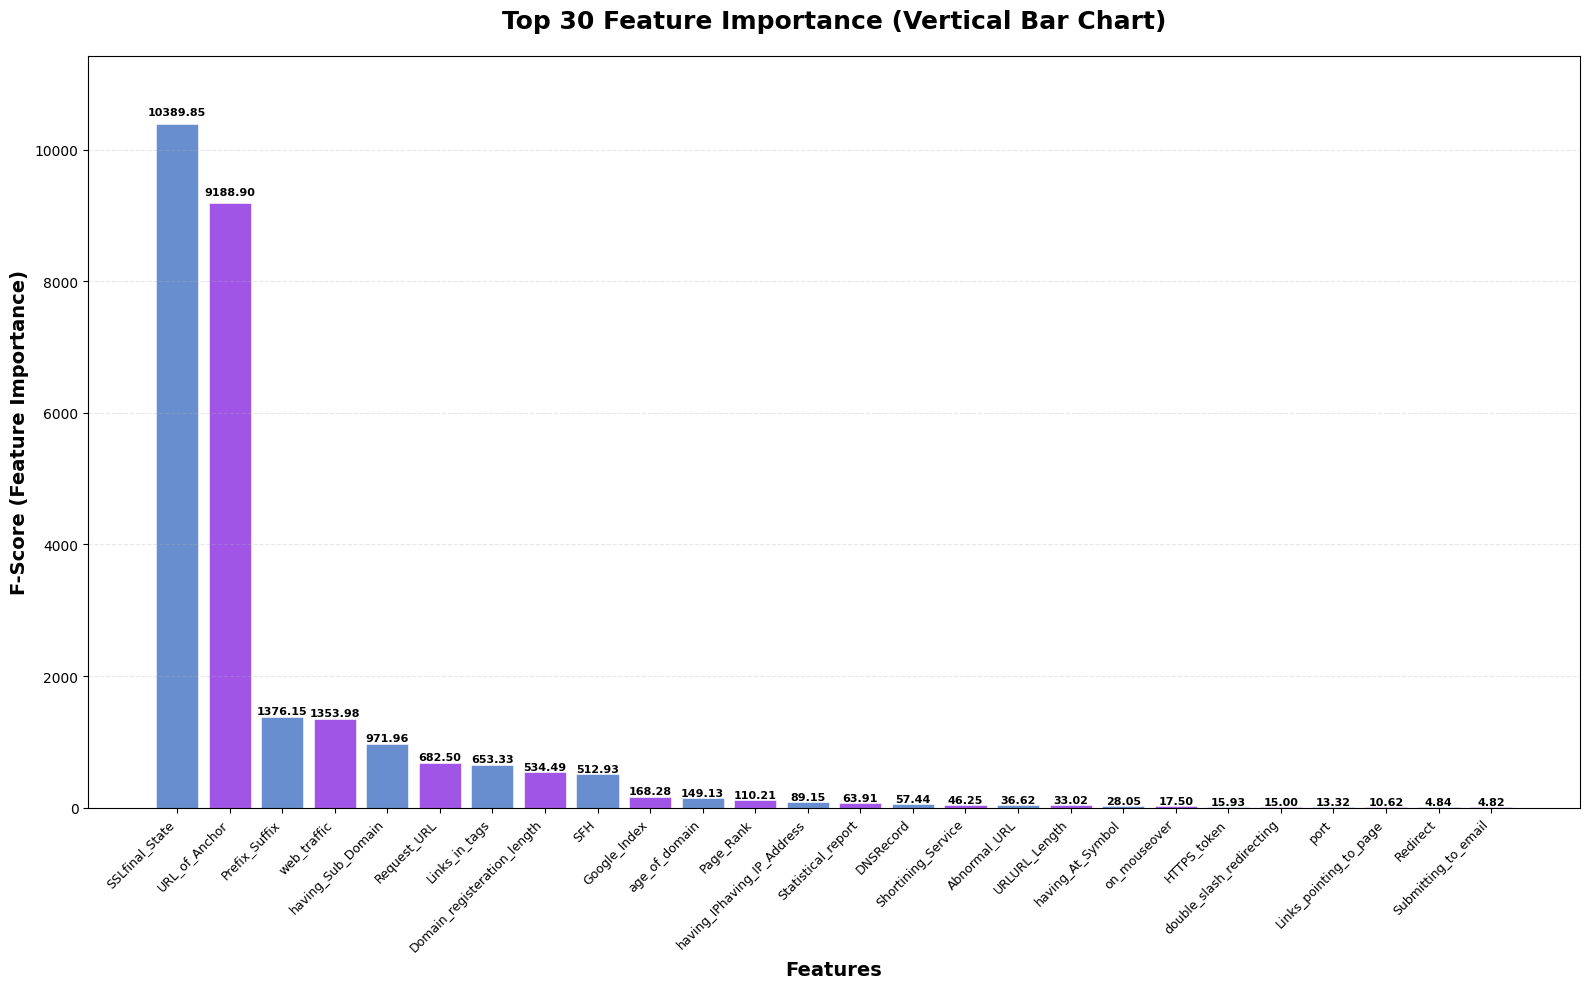


--- Top 30 Feature Importance Values ---
 1. SSLfinal_State: 10389.85
 2. URL_of_Anchor: 9188.90
 3. Prefix_Suffix: 1376.15
 4. web_traffic: 1353.98
 5. having_Sub_Domain: 971.96
 6. Request_URL: 682.50
 7. Links_in_tags: 653.33
 8. Domain_registeration_length: 534.49
 9. SFH: 512.93
10. Google_Index: 168.28
11. age_of_domain: 149.13
12. Page_Rank: 110.21
13. having_IPhaving_IP_Address: 89.15
14. Statistical_report: 63.91
15. DNSRecord: 57.44
16. Shortining_Service: 46.25
17. Abnormal_URL: 36.62
18. URLURL_Length: 33.02
19. having_At_Symbol: 28.05
20. on_mouseover: 17.50
21. HTTPS_token: 15.93
22. double_slash_redirecting: 15.00
23. port: 13.32
24. Links_pointing_to_page: 10.62
25. Redirect: 4.84
26. Submitting_to_email: 4.82


In [11]:
# Create Top 30 Feature Importance Vertical Bar Chart (Similar to provided image)
import matplotlib.pyplot as plt
import numpy as np

# Get top 30 features
top_30_features = mean_importance.head(30)

# Create figure with larger size to accommodate 30 features
plt.figure(figsize=(16, 10))

# Create vertical bar chart with alternating colors (blue and purple like in the image)
colors = ['#4472C4' if i % 2 == 0 else '#8A2BE2' for i in range(len(top_30_features))]
bars = plt.bar(range(len(top_30_features)), top_30_features.values, 
               color=colors, alpha=0.8, edgecolor='white', linewidth=0.5)

# Add value labels on top of each bar
for i, (feature, importance) in enumerate(top_30_features.items()):
    plt.text(i, importance + importance*0.01, f'{importance:.2f}', 
             ha='center', va='bottom', fontsize=8, fontweight='bold')

# Customize the plot
plt.title('Top 30 Feature Importance (Vertical Bar Chart)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=14, fontweight='bold')
plt.ylabel('F-Score (Feature Importance)', fontsize=14, fontweight='bold')

# Set x-axis labels with rotation
plt.xticks(range(len(top_30_features)), top_30_features.index, 
           rotation=45, ha='right', fontsize=9)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Set y-axis to start from 0 for better comparison
plt.ylim(0, top_30_features.iloc[0] * 1.1)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print the top 30 values for reference
print("\n--- Top 30 Feature Importance Values ---")
for i, (feature, importance) in enumerate(top_30_features.items(), 1):
    print(f"{i:2d}. {feature}: {importance:.2f}")

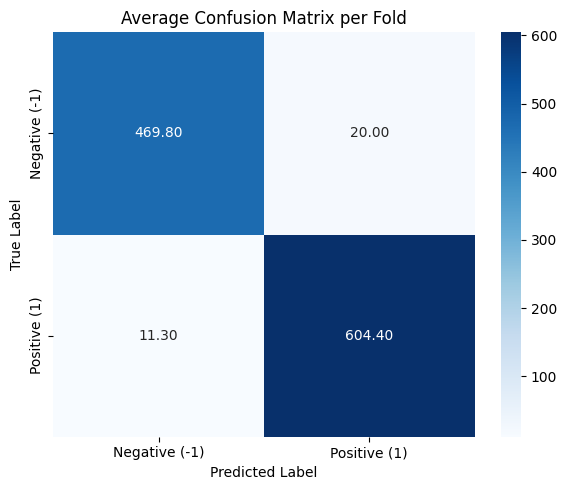

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

avg_cm = np.array([[avg_tn, avg_fp],
                   [avg_fn, avg_tp]])

labels = ['Negative (-1)', 'Positive (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title("Average Confusion Matrix per Fold")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Execution Time Visualization per Fold

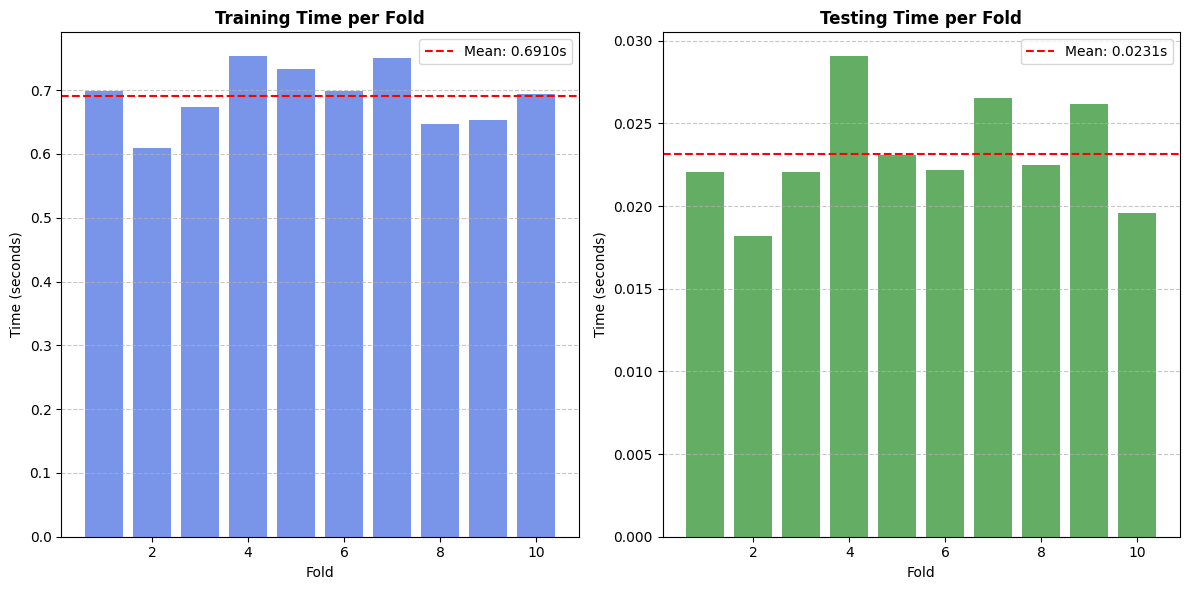

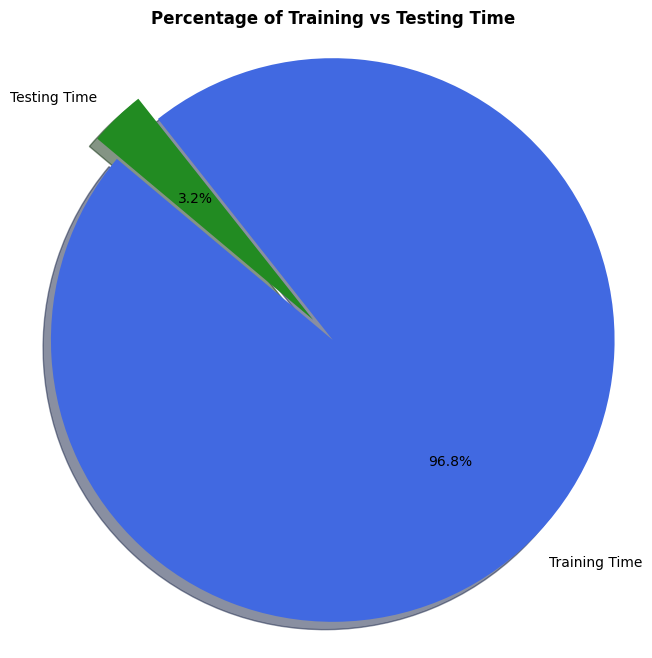

In [13]:
# Visualization of training and testing time per fold
import matplotlib.pyplot as plt

folds = list(range(1, 11))  # 10 folds from CV

plt.figure(figsize=(12, 6))

# Plot training time
plt.subplot(1, 2, 1)
plt.bar(folds, train_times, color='royalblue', alpha=0.7)
plt.axhline(y=np.mean(train_times), color='red', linestyle='--', label=f'Mean: {np.mean(train_times):.4f}s')
plt.title('Training Time per Fold', fontweight='bold')
plt.xlabel('Fold')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Plot testing time
plt.subplot(1, 2, 2)
plt.bar(folds, test_times, color='forestgreen', alpha=0.7)
plt.axhline(y=np.mean(test_times), color='red', linestyle='--', label=f'Mean: {np.mean(test_times):.4f}s')
plt.title('Testing Time per Fold', fontweight='bold')
plt.xlabel('Fold')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

# Pie chart comparing training and testing time
plt.figure(figsize=(8, 8))
total_time = np.sum(train_times) + np.sum(test_times)
labels = ['Training Time', 'Testing Time']
sizes = [np.sum(train_times)/total_time*100, np.sum(test_times)/total_time*100]
colors = ['royalblue', 'forestgreen']
explode = (0.1, 0)  # explode the 1st slice (Training)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Percentage of Training vs Testing Time', fontweight='bold')
plt.show()

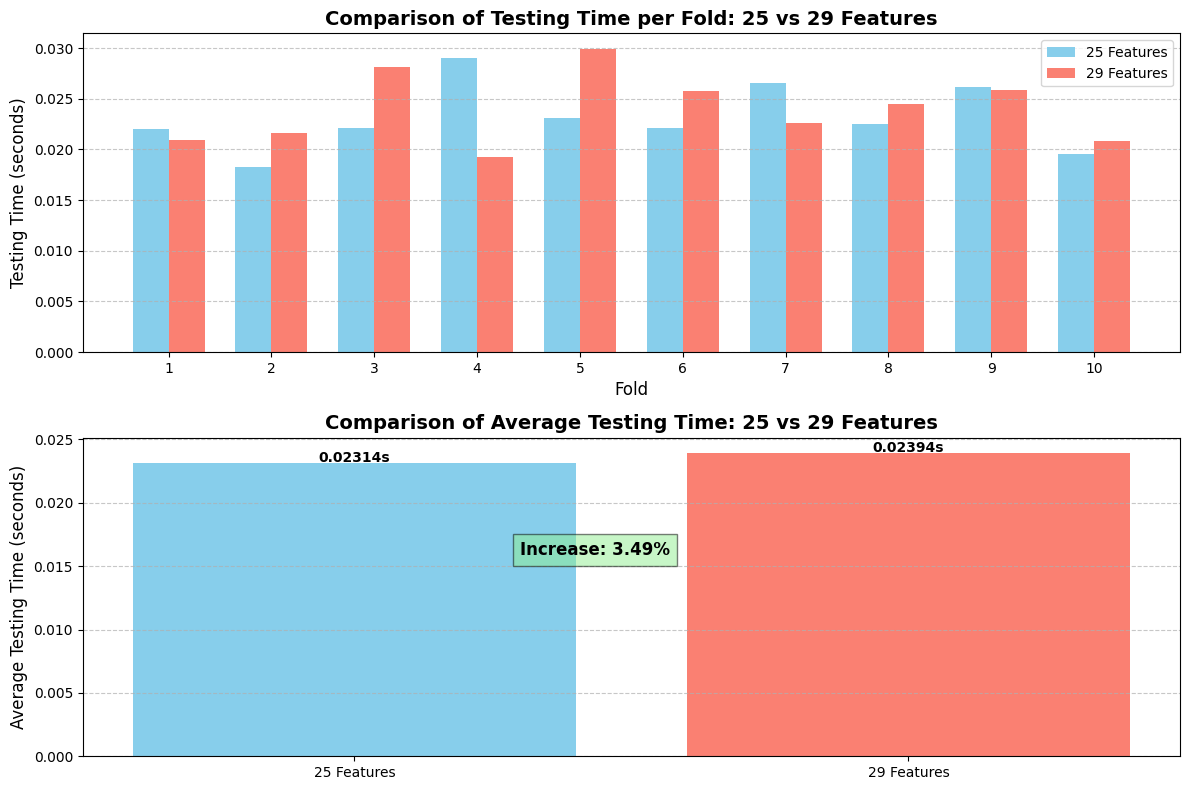


--- Testing Time Comparison: 25 vs 29 Features ---
Average Testing Time (25 Features): 0.02314 seconds
Average Testing Time (29 Features): 0.02394 seconds
Absolute Difference: 0.00081 seconds
Relative Difference: 3.49%


In [14]:
### Comparison of testing time between 25 and 29 features
import matplotlib.pyplot as plt
import numpy as np
import time

# Save data for 25 features
test_times_25 = test_times.copy()
mean_test_time_25 = np.mean(test_times_25)

# Run model with 29 features for comparison
SELECT_K_29 = 29
test_times_29 = []

# Use the same k-fold as before
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    # Split the already scaled data
    X_train_scaled, X_test_scaled = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Calculate F-score and p-value
    f_scores, p_values = f_classif(X_train_scaled, y_train)

    # Select feature indices with smallest p-values
    selected_indices_29 = np.argsort(p_values)[:SELECT_K_29]

    # Feature selection based on p-value
    X_train_selected_29 = X_train_scaled[:, selected_indices_29]
    X_test_selected_29 = X_test_scaled[:, selected_indices_29]

    # Train model with 29 features
    rf_model_29 = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model_29.fit(X_train_selected_29, y_train)

    # Test and measure testing time for 29 features
    test_start_time = time.time()
    y_pred_29 = rf_model_29.predict(X_test_selected_29)
    test_end_time = time.time()
    test_time_29 = test_end_time - test_start_time
    test_times_29.append(test_time_29)

# Calculate average testing time for 29 features
mean_test_time_29 = np.mean(test_times_29)

# Visualization comparing testing time between 25 and 29 features
plt.figure(figsize=(12, 8))

# Per-fold comparison
plt.subplot(2, 1, 1)
x = np.arange(1, 11)
width = 0.35

bars1 = plt.bar(x - width/2, test_times_25, width, label='25 Features', color='skyblue')
bars2 = plt.bar(x + width/2, test_times_29, width, label='29 Features', color='salmon')

plt.xlabel('Fold', fontsize=12)
plt.ylabel('Testing Time (seconds)', fontsize=12)
plt.title('Comparison of Testing Time per Fold: 25 vs 29 Features', fontsize=14, fontweight='bold')
plt.xticks(x)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Average testing time
plt.subplot(2, 1, 2)
avg_times = [mean_test_time_25, mean_test_time_29]
labels = ['25 Features', '29 Features']
colors = ['skyblue', 'salmon']

bars = plt.bar(labels, avg_times, color=colors)
plt.ylabel('Average Testing Time (seconds)', fontsize=12)
plt.title('Comparison of Average Testing Time: 25 vs 29 Features', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values above bars
for i, v in enumerate(avg_times):
    plt.text(i, v + 0.0001, f'{v:.5f}s', ha='center', fontweight='bold')

# Add percentage change
percent_change = ((mean_test_time_29 - mean_test_time_25) / mean_test_time_25) * 100
increase_text = f'Increase: {percent_change:.2f}%' if percent_change > 0 else f'Decrease: {abs(percent_change):.2f}%'
plt.figtext(0.5, 0.3, increase_text, ha='center', fontsize=12, fontweight='bold', 
           bbox={'facecolor':'lightgreen', 'alpha':0.5, 'pad':5})

plt.tight_layout()
plt.show()

# Print comparison results
print("\n--- Testing Time Comparison: 25 vs 29 Features ---")
print(f"Average Testing Time (25 Features): {mean_test_time_25:.5f} seconds")
print(f"Average Testing Time (29 Features): {mean_test_time_29:.5f} seconds")
print(f"Absolute Difference: {abs(mean_test_time_29 - mean_test_time_25):.5f} seconds")
print(f"Relative Difference: {percent_change:.2f}%")

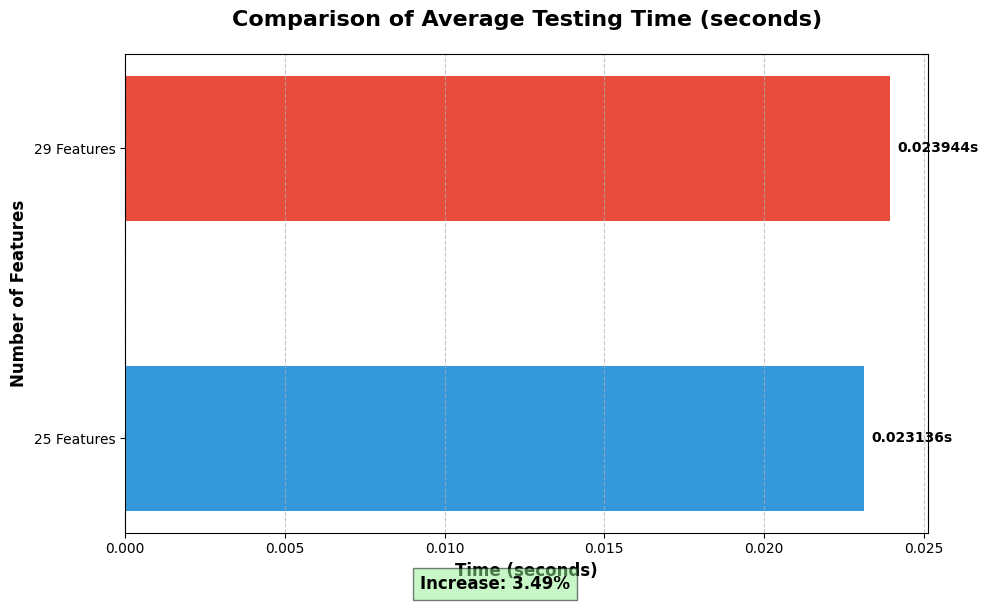

In [15]:
# Additional Visualization: Horizontal bar chart for clearer comparison
plt.figure(figsize=(10, 6))

# Data
categories = ['25 Features', '29 Features']
values = [mean_test_time_25, mean_test_time_29]
colors = ['#3498db', '#e74c3c']

# Plot horizontal bar chart
bars = plt.barh(categories, values, color=colors, height=0.5)

# Add values at the end of bars
for i, v in enumerate(values):
    plt.text(v + v*0.01, i, f'{v:.6f}s', va='center', fontweight='bold')

# Add title and labels
plt.title('Comparison of Average Testing Time (seconds)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Time (seconds)', fontsize=12, fontweight='bold')
plt.ylabel('Number of Features', fontsize=12, fontweight='bold')

# Add grid for easier reading
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage change information
percent_change_text = f'Increase: {percent_change:.2f}%' if percent_change > 0 else f'Decrease: {abs(percent_change):.2f}%'
plt.figtext(0.5, 0.01, percent_change_text, ha='center', fontsize=12, fontweight='bold', 
           bbox={'facecolor':'lightgreen', 'alpha':0.5, 'pad':5})

plt.tight_layout()
plt.show()


--- Running 5 test iterations for more reliable timing ---
Run 1/5...
Run 2/5...
Run 2/5...
Run 3/5...
Run 3/5...
Run 4/5...
Run 4/5...
Run 5/5...
Run 5/5...

--- Testing Time Comparison (Average of 5 runs) ---
25 Features - Individual run means: ['0.025571s', '0.027123s', '0.023386s', '0.021434s', '0.020602s']
29 Features - Individual run means: ['0.023390s', '0.025749s', '0.023606s', '0.021566s', '0.022183s']
25 Features - Final average: 0.023623 seconds
29 Features - Final average: 0.023299 seconds

--- Testing Time Comparison (Average of 5 runs) ---
25 Features - Individual run means: ['0.025571s', '0.027123s', '0.023386s', '0.021434s', '0.020602s']
29 Features - Individual run means: ['0.023390s', '0.025749s', '0.023606s', '0.021566s', '0.022183s']
25 Features - Final average: 0.023623 seconds
29 Features - Final average: 0.023299 seconds


<Figure size 1000x800 with 0 Axes>

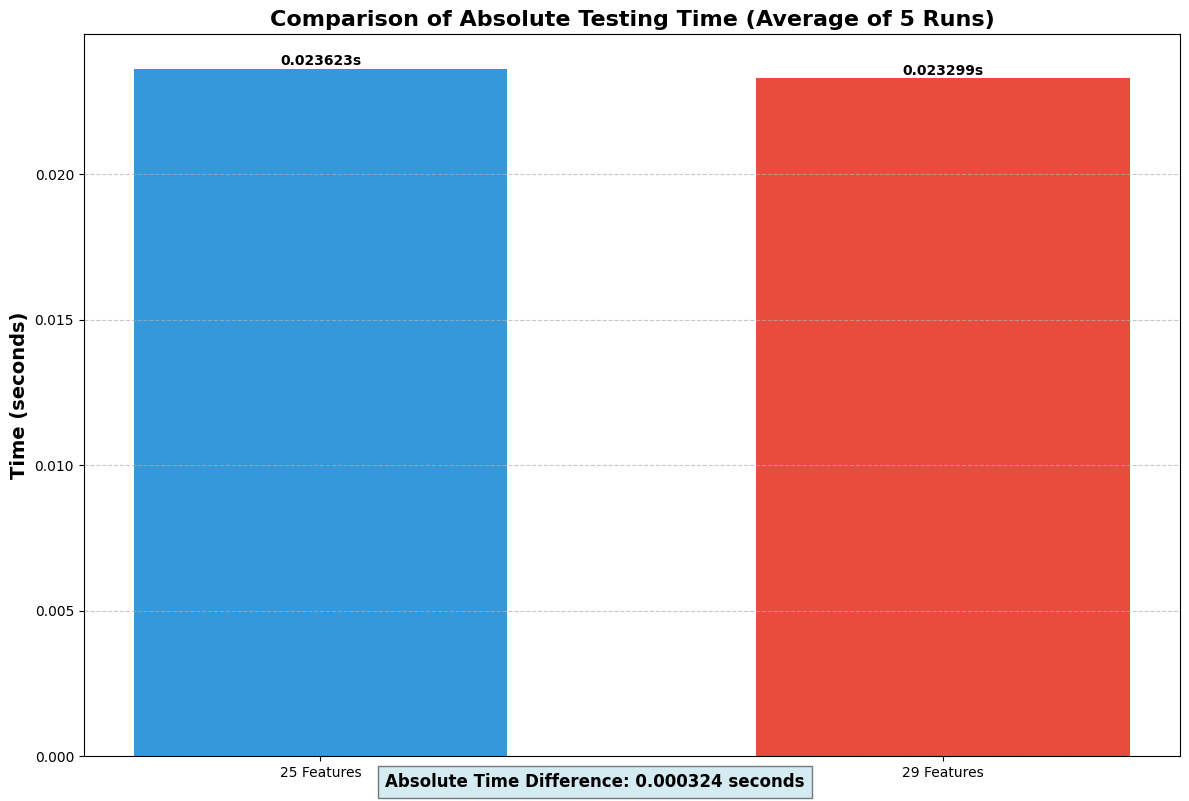

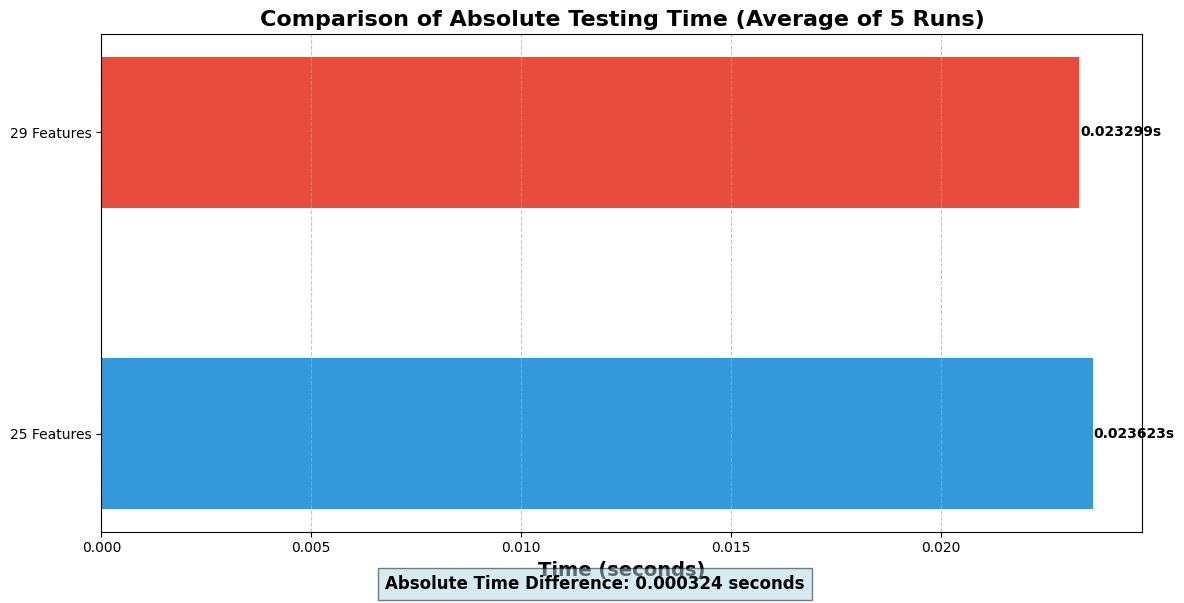

In [16]:
# Additional Visualization: Bar chart for absolute time comparison with 5 test runs
plt.figure(figsize=(10, 8))

# Run the test 5 times for each feature set and calculate average
n_runs = 5
test_times_25_multiple = []
test_times_29_multiple = []

print(f"\n--- Running {n_runs} test iterations for more reliable timing ---")

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}...")
    
    # Test times for 25 features (run multiple times)
    run_times_25 = []
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_test_selected = X_scaled[test_idx][:, np.argsort(p_values)[:SELECT_K]]
        
        # Measure testing time
        test_start_time = time.time()
        _ = rf_model.predict(X_test_selected)
        test_end_time = time.time()
        run_times_25.append(test_end_time - test_start_time)
    
    # Test times for 29 features (run multiple times)
    run_times_29 = []
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_test_selected_29 = X_scaled[test_idx][:, np.argsort(p_values)[:SELECT_K_29]]
        
        # Measure testing time
        test_start_time = time.time()
        _ = rf_model_29.predict(X_test_selected_29)
        test_end_time = time.time()
        run_times_29.append(test_end_time - test_start_time)
    
    # Save average times for this run
    test_times_25_multiple.append(np.mean(run_times_25))
    test_times_29_multiple.append(np.mean(run_times_29))

# Calculate final average over all runs
mean_test_time_25_multi = np.mean(test_times_25_multiple)
mean_test_time_29_multi = np.mean(test_times_29_multiple)

# Print detailed results of multiple runs
print("\n--- Testing Time Comparison (Average of 5 runs) ---")
print(f"25 Features - Individual run means: {[f'{t:.6f}s' for t in test_times_25_multiple]}")
print(f"29 Features - Individual run means: {[f'{t:.6f}s' for t in test_times_29_multiple]}")
print(f"25 Features - Final average: {mean_test_time_25_multi:.6f} seconds")
print(f"29 Features - Final average: {mean_test_time_29_multi:.6f} seconds")

# Calculate absolute difference
absolute_diff = mean_test_time_29_multi - mean_test_time_25_multi

# Data for bar chart
labels = ['25 Features', '29 Features']
values = [mean_test_time_25_multi, mean_test_time_29_multi]
colors = ['#3498db', '#e74c3c']

# Create bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(labels, values, color=colors, width=0.6)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.00002,
            f'{height:.6f}s', ha='center', va='bottom', fontweight='bold')

# Customize the plot
plt.title('Comparison of Absolute Testing Time (Average of 5 Runs)', fontsize=16, fontweight='bold')
plt.ylabel('Time (seconds)', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add absolute time difference as text annotation
diff_text = f"Absolute Time Difference: {abs(absolute_diff):.6f} seconds"
plt.figtext(0.5, 0.01, diff_text, ha='center', fontsize=12, fontweight='bold', 
           bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':5})

plt.tight_layout()
plt.show()

# Create horizontal bar chart for clearer visualization
plt.figure(figsize=(12, 6))

# Horizontal bar chart
bars_h = plt.barh(labels, values, color=colors, height=0.5)

# Add value labels at the end of bars
for i, bar in enumerate(bars_h):
    width = bar.get_width()
    plt.text(width + 0.00002, i, f'{width:.6f}s', va='center', ha='left', fontweight='bold')

# Customize the plot
plt.title('Comparison of Absolute Testing Time (Average of 5 Runs)', fontsize=16, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add absolute time difference as text annotation
plt.figtext(0.5, 0.01, diff_text, ha='center', fontsize=12, fontweight='bold', 
           bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':5})

plt.tight_layout()
plt.show()